# Data cleaning and prep

In [2]:
# HIDE
import pandas as pd
import numpy as np
np.random.seed(7)
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", palette=[sns.color_palette('muted')[i] for i in [0,2]], 
        color_codes=True, context="talk")
from IPython import display
%matplotlib inline

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

#import keras as ke
#import keras.backend as K
import tensorflow as tf
from tensorflow.python.keras.layers import Input, Dense, Dropout
from tensorflow.python.keras.models import Model

create_gif = False

print(f"sklearn: {sk.__version__}")
print(f"pandas: {pd.__version__}")
print(f"tensorflow: {tf.__version__}")

sklearn: 1.0.2
pandas: 1.4.1
tensorflow: 2.10.0


In [42]:
# Importing data and Preparation of data 
df = pd.read_csv('data/compas-scores-raw.csv')

df['DateOfBirth'] = pd.to_datetime(df['DateOfBirth'])
current_year = dt.datetime.now().year
# Check if the year is greater than the current year minus 100
df['DateOfBirth'] = df['DateOfBirth'].apply(lambda x: x.replace(year=x.year - 100) if x.year > current_year else x)
df['Screening_Date'] = pd.to_datetime(df['Screening_Date'])
df['Age'] = (df['Screening_Date'] - df['DateOfBirth']).astype('<m8[Y]')

df_cleaned = df.dropna(subset=['ScoreText'])
df_cleaned.isnull().sum()
data_types = df_cleaned.dtypes
for column in df_cleaned.columns:
    unique_values = df_cleaned[column].unique()
df_cleaned["Ethnic_Code_Text"].replace({"African-Am": "African-American"}, inplace=True)

columns_to_drop = ['Person_ID','AssessmentID','Case_ID','LastName','FirstName','MiddleName','DateOfBirth','ScaleSet_ID','AssessmentReason','Screening_Date','RecSupervisionLevelText','Scale_ID','RecSupervisionLevel','RawScore','DecileScore','AssessmentType','IsCompleted','IsDeleted']
df = df_cleaned.drop(columns=columns_to_drop)
df.rename(columns = {'Sex_Code_Text':'sex'}, inplace = True)
df.rename(columns = {'Ethnic_Code_Text':'ethnic'},inplace = True) 

# Modify Ethnic column
df['ethnic'] = df['ethnic'].apply(lambda x: 'African-American' if x == 'African-American' else 'Other Ethnicity')

# One-hot encode Ethnic column
df['Ethnic_African-American'] = (df['ethnic'] == 'African-American').astype(int)

# Drop the original 'Ethnic' column as it's no longer needed
df.drop(columns=['ethnic'], inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60798 entries, 0 to 60842
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Agency_Text              60798 non-null  object 
 1   sex                      60798 non-null  object 
 2   ScaleSet                 60798 non-null  object 
 3   Language                 60798 non-null  object 
 4   LegalStatus              60798 non-null  object 
 5   CustodyStatus            60798 non-null  object 
 6   MaritalStatus            60798 non-null  object 
 7   DisplayText              60798 non-null  object 
 8   ScoreText                60798 non-null  object 
 9   Age                      60798 non-null  float64
 10  Ethnic_African-American  60798 non-null  int64  
dtypes: float64(1), int64(1), object(9)
memory usage: 5.6+ MB


/var/folders/kj/r7j0kbg97txb4fjzd4zq17dh0000gn/T/ipykernel_21798/3118456885.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["Ethnic_Code_Text"].replace({"African-Am": "African-American"}, inplace=True)


## Preparing for training 

In [73]:
from sklearn.preprocessing import StandardScaler

# Define the load_data function
def load_data():
    # Assuming df is your DataFrame containing the dataset
    data = df.copy()  # Make a copy of the DataFrame to avoid modifying the original data
    sensitive_atts = ['sex', 'Ethnic_African-American']
    
    # Form Z by selecting the binary columns for the sensitive attributes
    Z = data[sensitive_atts].copy()  # Create a copy of the selected columns
    
    ## Form y which is the target 
    original_y = data['ScoreText']
    # Convert string labels to numeric values
    y_mapping = {'Low': 0, 'Medium': 0.5, 'High': 1}
    original_y = original_y.map(y_mapping)
    
    # Define thresholds for determining low, medium, and high likelihood of recidivism
    low_threshold = 0.33
    high_threshold = 0.66
    # Map original target values to low, medium, and high classes
    y_low = (original_y <= low_threshold).astype(int)
    y_medium = ((original_y > low_threshold) & (original_y <= high_threshold)).astype(int)
    y_high = (original_y > high_threshold).astype(int)
    
    # Features; note that the target and sensitive attribute columns are dropped
    X = (data
         .drop(columns=['ScoreText', 'sex', 'Ethnic_African-American'])
         .fillna('Unknown')
         .pipe(pd.get_dummies, drop_first=True))  # One-hot encode categorical variables
    
    print(f"Features X: {X.shape[0]} samples, {X.shape[1]} attributes")
    print(f"Original targets y: {original_y.shape[0]} samples")
    print(f"Low recidivism targets y_low: {y_low.shape[0]} samples")
    print(f"Medium recidivism targets y_medium: {y_medium.shape[0]} samples")
    print(f"High recidivism targets y_high: {y_high.shape[0]} samples")
    print(f"Sensitive attributes Z: {Z.shape[0]} samples, {Z.shape[1]} attributes")
    return X, y_low, y_medium, y_high, Z

# Load the data
X, yl, ym, yh, Z = load_data()

# Split the data for X, y_low, y_medium, y_high, and Z separately
X_train, X_test, yl_train, yl_test = train_test_split(X, yl, test_size=0.5, stratify=yl, random_state=7)
X_train, X_test, ym_train, ym_test = train_test_split(X, ym, test_size=0.5, stratify=ym, random_state=7)
X_train, X_test, yh_train, yh_test = train_test_split(X, yh, test_size=0.5, stratify=yh, random_state=7)
Z_train, Z_test = train_test_split(Z, test_size=0.5, stratify=Z['sex'], random_state=7)  # Corrected Z

# Standardize the features using StandardScaler
scaler_X = StandardScaler().fit(X_train)
X_train_scaled = scaler_X.transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

Features X: 60798 samples, 25 attributes
Original targets y: 60798 samples
Low recidivism targets y_low: 60798 samples
Medium recidivism targets y_medium: 60798 samples
High recidivism targets y_high: 60798 samples
Sensitive attributes Z: 60798 samples, 2 attributes


## Training and predicting basic docile score predictor 

In [76]:
# Define neural network classifier function
def nn_classifier(n_features):
    inputs = Input(shape=(n_features,))
    dense1 = Dense(32, activation='relu')(inputs)
    dropout1 = Dropout(0.4)(dense1)
    dense2 = Dense(32, activation='relu')(dropout1)
    dropout2 = Dropout(0.4)(dense2)
    dense3 = Dense(32, activation="relu")(dropout2)
    dropout3 = Dropout(0.4)(dense3)
    outputs = Dense(1, activation='sigmoid')(dropout3)
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

# Initialize and train neural network classifiers for each target variable

# Classifier for y_low
clf_yl = nn_classifier(n_features=X_train_scaled.shape[1])
history_yl = clf_yl.fit(X_train_scaled, yl_train, epochs=20, verbose=0)

# Classifier for y_medium
clf_ym = nn_classifier(n_features=X_train_scaled.shape[1])
history_ym = clf_ym.fit(X_train_scaled, ym_train, epochs=20, verbose=0)

# Classifier for y_high
clf_yh = nn_classifier(n_features=X_train_scaled.shape[1])
history_yh = clf_yh.fit(X_train_scaled, yh_train, epochs=20, verbose=0)

# Predict on test set for y_low classifier
y_low_pred = pd.Series(clf_yl.predict(X_test_scaled).ravel(), index=yl_test.index)
print("For y_low classifier:")
print(f"ROC AUC: {roc_auc_score(yl_test, y_low_pred):.2f}")
print(f"Accuracy: {100*accuracy_score(yl_test, (y_low_pred > 0.5)):.1f}%")

# Predict on test set for y_medium classifier
y_medium_pred = pd.Series(clf_ym.predict(X_test_scaled).ravel(), index=ym_test.index)
print("For y_medium classifier:")
print(f"ROC AUC: {roc_auc_score(ym_test, y_medium_pred):.2f}")
print(f"Accuracy: {100*accuracy_score(ym_test, (y_medium_pred > 0.5)):.1f}%")

# Predict on test set for y_high classifier
y_high_pred = pd.Series(clf_yh.predict(X_test).ravel(), index=yh_test.index)  # Use X_test instead of X_test_scaled
print("For y_high classifier:")
print(f"ROC AUC: {roc_auc_score(yh_test, y_high_pred):.2f}")
print(f"Accuracy: {100*accuracy_score(yh_test, (y_high_pred > 0.5)):.1f}%")

For y_low classifier:
ROC AUC: 0.50
Accuracy: 68.2%
For y_medium classifier:
ROC AUC: 0.50
Accuracy: 79.5%
For y_high classifier:
ROC AUC: 0.64
Accuracy: 88.8%


# Quanlitative Model fairness 

Processing attribute: sex
Processing attribute: Ethnic_African-American
legend: {'Ethnic_African-American': ['African-American', 'Other Ethnicity'], 'sex': ['female', 'male']}
Processing attribute: sex
Processing attribute: Ethnic_African-American
legend: {'Ethnic_African-American': ['African-American', 'Other Ethnicity'], 'sex': ['female', 'male']}
Processing attribute: sex
Processing attribute: Ethnic_African-American
legend: {'Ethnic_African-American': ['African-American', 'Other Ethnicity'], 'sex': ['female', 'male']}


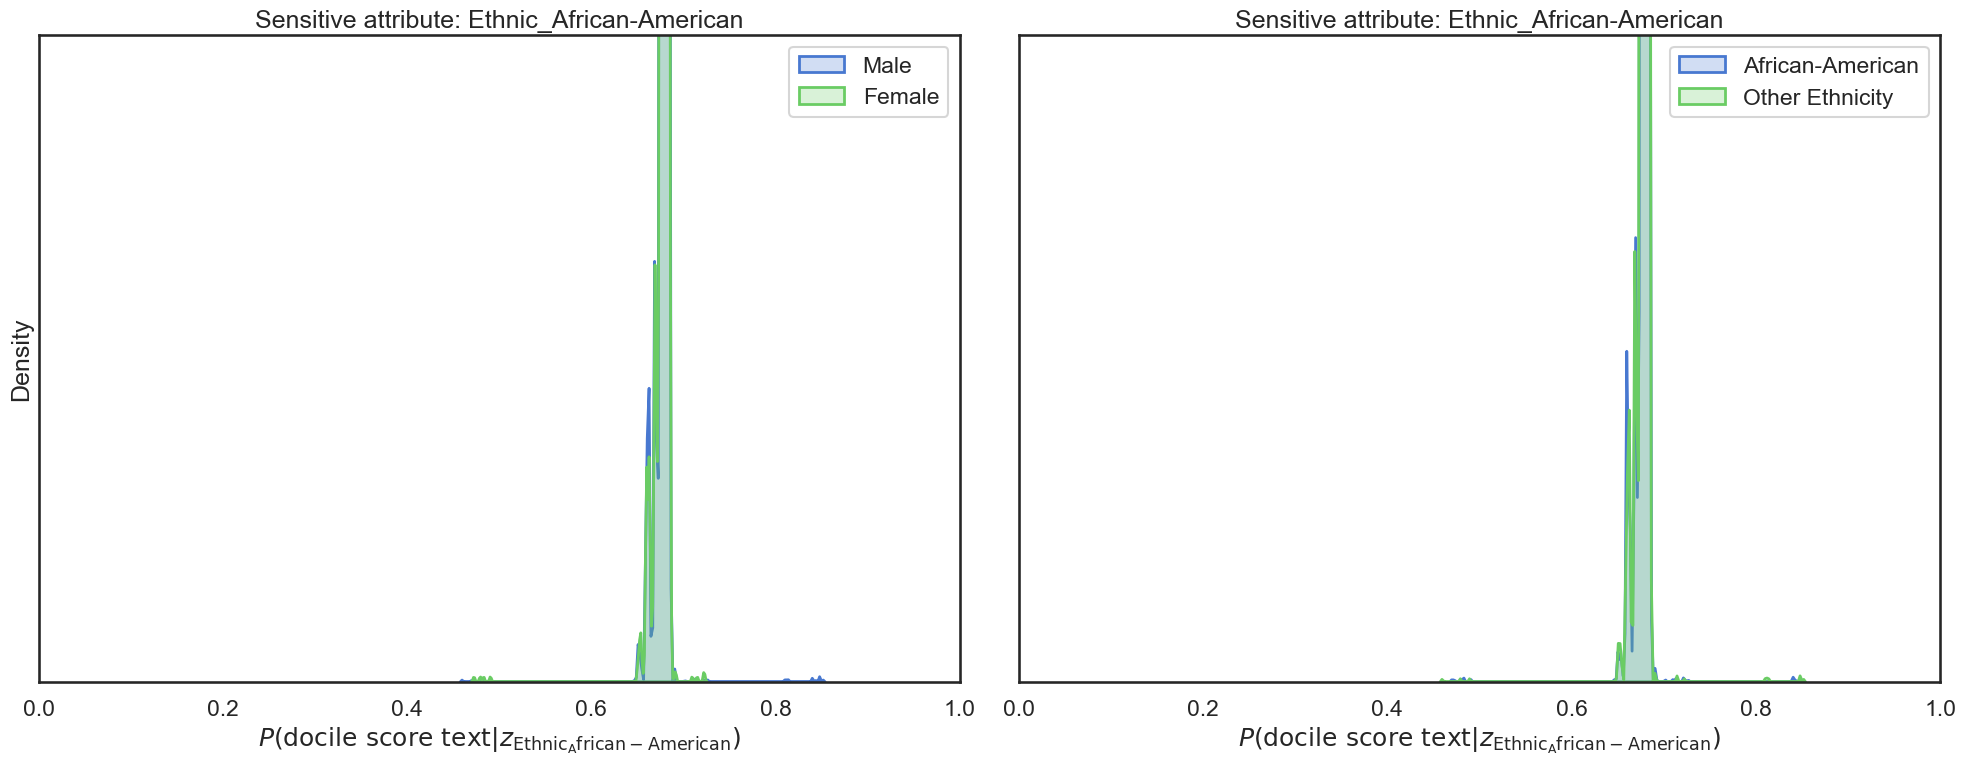

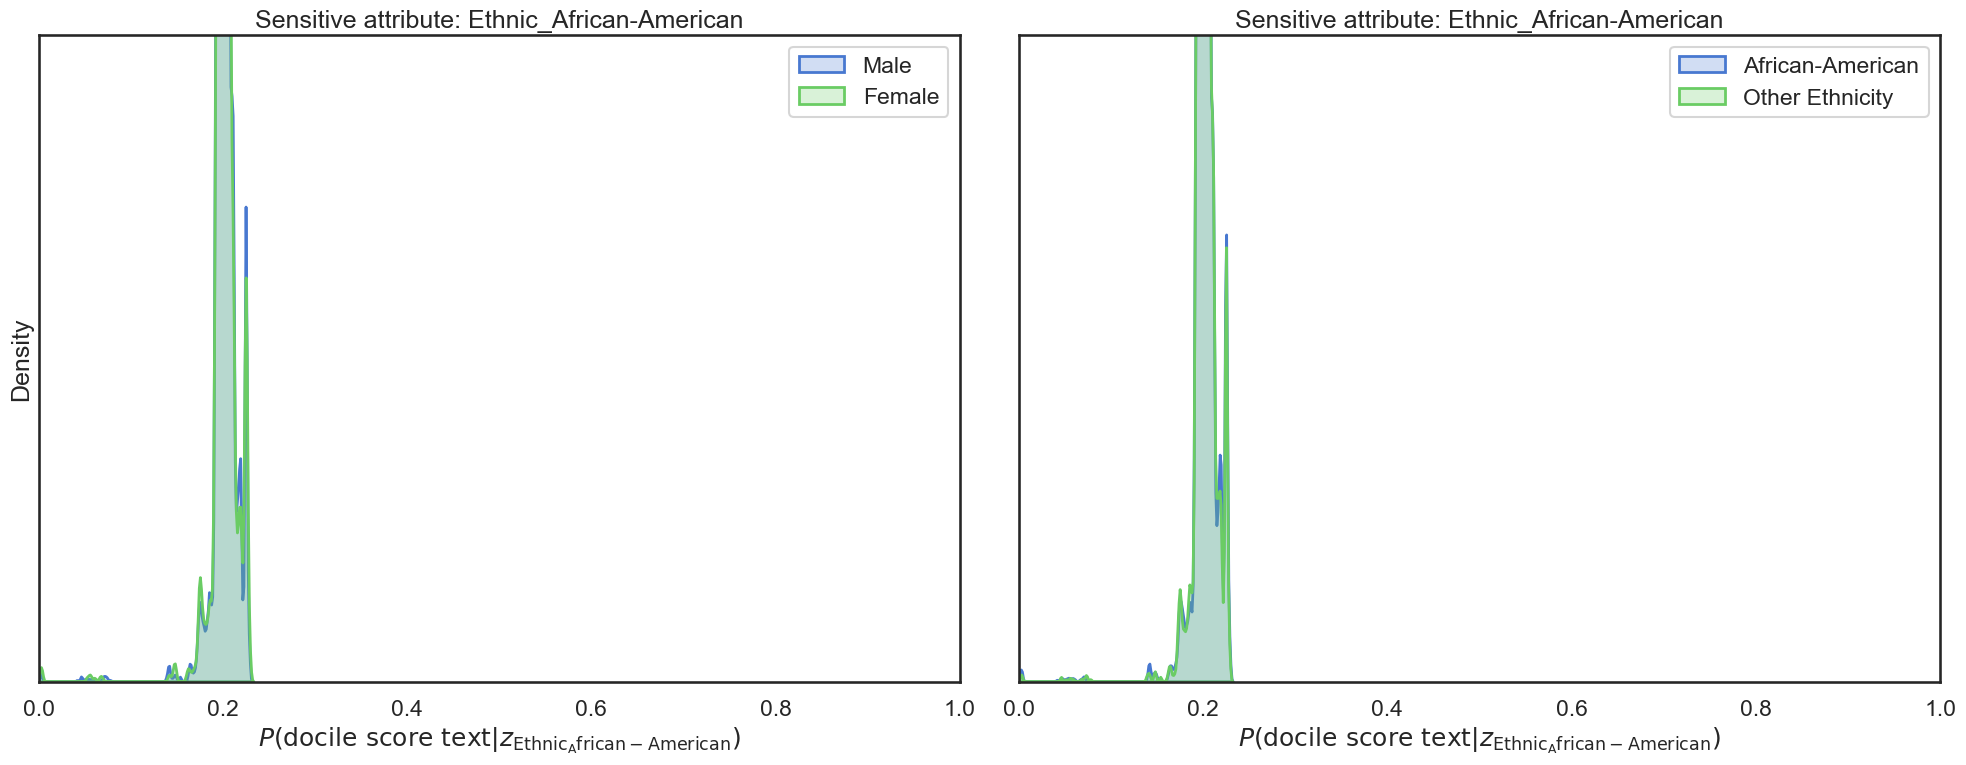

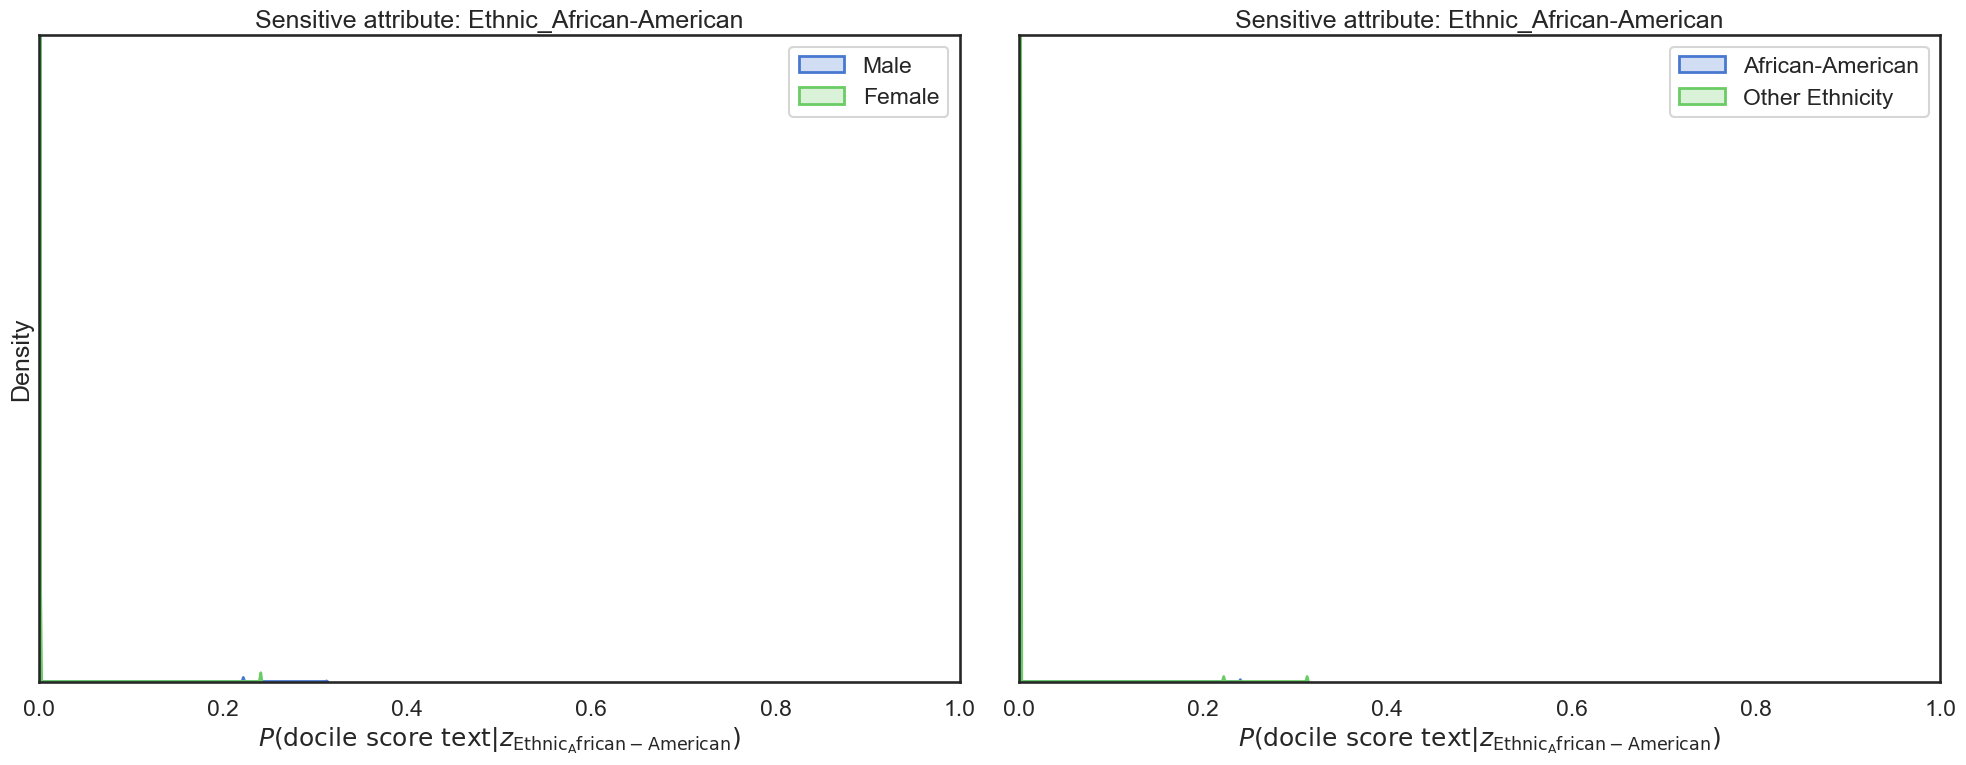

In [96]:
# Define the plot_distributions function
import os
def plot_distributions(y, Z, iteration=None, val_metrics=None, p_rules=None, fname=None):
    fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)  # Increase figure size
    legend = {'Ethnic_African-American': ['African-American', 'Other Ethnicity'], 'sex': ['female', 'male']}
    for idx, attr in enumerate(Z.columns):
        print(f"Processing attribute: {attr}")  # Print the attribute being processed
        try:
            if attr == 'sex':
                for attr_val in Z[attr].unique():
                    indexed_y = y[Z[attr] == attr_val]
                    ax = sns.kdeplot(data=indexed_y,
                                     label='{}'.format(attr_val), 
                                     ax=axes[idx], fill=True, lw=2)  # Increase line width
            else:
                for attr_val in [0, 1]:
                    indexed_y = y[Z[attr].reset_index(drop=True) == attr_val]
                    ax = sns.kdeplot(data=indexed_y,
                                     label='{}'.format(legend[attr][attr_val]), 
                                     ax=axes[idx], fill=True, lw=2)  # Increase line width
        except KeyError as e:
            print(f"KeyError occurred for attribute: {attr}, error: {e}")
    # Add legend
    axes[0].legend()
    axes[1].legend()
    
    for ax in axes:
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 7)
        ax.set_yticks([])
        ax.set_title("Sensitive attribute: {}".format(attr))
        if idx == 0:
            ax.set_ylabel('Prediction distribution')
        ax.set_xlabel(r'$P(\mathrm{{docile\ score\ text}}|z_{{\mathrm{{{}}}}})$'.format(attr))

    if iteration:
        fig.text(1.0, 0.9, f"Training iteration #{iteration}", fontsize='16')
    if val_metrics is not None:
        fig.text(1.0, 0.65, '\n'.join(["Prediction performance:",
                                       f"- ROC AUC: {val_metrics['ROC AUC']:.2f}",
                                       f"- Accuracy: {val_metrics['Accuracy']:.1f}"]),
                 fontsize='16')

    if p_rules is not None:
        fig.text(1.0, 0.4, '\n'.join(["Satisfied p%-rules:"] +
                                     [f"- {attr}: {p_rules[attr]:.0f}%-rule" 
                                      for attr in p_rules.keys()]), 
                 fontsize='16')
    fig.tight_layout()
    if fname is not None:
        plt.savefig(fname, bbox_inches='tight', dpi=300)

    print("legend:",legend)

    return fig, legend
y_low_pred_reset_index = y_low_pred.reset_index(drop=True)
y_medium_pred_reset_index = y_medium_pred.reset_index(drop=True)
y_high_pred_reset_index = y_high_pred.reset_index(drop=True)
Z_test_reset_index = Z_test.reset_index(drop=True)

# Create the directory if it doesn't exist
os.makedirs('images/', exist_ok=True)
# Plot for y_low classifier
fig, legend = plot_distributions(y_low_pred_reset_index, Z_test_reset_index, fname='images/y_low_distributions.png')


# Plot for y_medium classifier
fig, legend = plot_distributions(y_medium_pred_reset_index, Z_test_reset_index, fname='images/y_low_distributions.png')


# Plot for y_high classifier
fig, legend = plot_distributions(y_high_pred_reset_index, Z_test_reset_index, fname='images/y_high_distributions.png')






## Quantitative Model Fairness

In [100]:
def p_rule(y_pred, Z_values, threshold=0.5):
    # Convert y_pred and Z_values to numpy arrays for easier manipulation
    y_pred_np = np.array(y_pred)
    Z_values_np = np.array(Z_values)
    
    # Calculate the predicted outcomes for each sensitive attribute value
    y_z_1 = y_pred_np[Z_values_np == 1]
    y_z_0 = y_pred_np[Z_values_np == 0]
    
    # Check if there are samples for both sensitive attribute values
    if len(y_z_1) == 0 or len(y_z_0) == 0:
        return 0  # Return 0 if there are no samples for one of the sensitive attribute values
    
    # Calculate the proportion of positive predictions
    prop_pos_z_1 = np.mean(y_z_1 > threshold)
    prop_pos_z_0 = np.mean(y_z_0 > threshold)
    
    # Calculate the p-rule
    p_rule_value = min(prop_pos_z_1 / prop_pos_z_0, prop_pos_z_0 / prop_pos_z_1) * 100

    return p_rule_value

# Check unique values and counts for the 'sex' attribute in the test set
sex_values = Z_test_reset_index['sex'].unique()
sex_counts = Z_test_reset_index['sex'].value_counts()

print("Unique values of 'sex' attribute:", sex_values)
print("Counts of each 'sex' attribute value:")
print(sex_counts)

# Check column names to ensure correctness
print("Column names in Z_test_reset_index:")
print(Z_test_reset_index.columns)
# Calculate and print the %p-rules for each sensitive attribute
print("The classifier satisfies the following %p-rules:")
print(f"\tGiven attribute 'Ethnic_African-American': {p_rule(y_low_pred_reset_index, Z_test_reset_index['Ethnic_African-American']):.0f}%-rule")
print(f"\tGiven attribute 'sex': {p_rule(y_low_pred_reset_index, Z_test_reset_index['sex']):.0f}%-rule")

print(Z_test_reset_index['sex'].head())



Unique values of 'sex' attribute: ['Male' 'Female']
Counts of each 'sex' attribute value:
Male      23740
Female     6659
Name: sex, dtype: int64
Column names in Z_test_reset_index:
Index(['sex', 'Ethnic_African-American'], dtype='object')
The classifier satisfies the following %p-rules:
	Given attribute 'Ethnic_African-American': 100%-rule
	Given attribute 'sex': 0%-rule
0      Male
1      Male
2      Male
3      Male
4    Female
Name: sex, dtype: object
